### Figure 3: Mean and STD bias plot

In [38]:
import numpy as np
# from esda.moran import Moran,Moran_Local
from libpysal.weights import lat2W
import seaborn as sns
# import pandas as pd
from matplotlib import colors
import matplotlib.pyplot as plt
# import properscoring as ps
import warnings
# from scipy import stats
# from utils.evaluation import plot_histogram,calc_peak,calc_mean
# from sklearn.metrics import mean_squared_error
# from math import sqrt
import xesmf as xe
from scipy import stats
warnings.filterwarnings("ignore")
sns.set_style("white")
sns.set_palette(sns.color_palette("Paired"))

In [3]:
def plot_anomaly(inputs,cmap,plot='save',vmin=-1,vmax=1,levels = False,mode='validation'):  
        fig, ax = plt.subplots(figsize=(5, 5))  
        ax.set_title('Anomaly')
        im = ax.imshow(inputs, interpolation='nearest', vmin=vmin,vmax=vmax,extent=None,cmap=cmap)
        ax.set(xticklabels=[])
        ax.set(yticklabels=[])
        cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
        if levels:
                plt.colorbar(im, cax=cax,levels = levels) # Similar to fig.colorbar(im, cax = cax)
        else:
                plt.colorbar(im, cax=cax)
        # plt.colorbar(im)

        if plot == 'save':
                plt.savefig('figs/input_images_%s.png' % mode,bbox_inches='tight')
                plt.clf()
        else:
                plt.show()

In [4]:
model = ''
# set mode
mode = 'validation'
print(np.load('/user/home/al18709/work/tc_data_mswep/valid_X.npy').shape)


# load datasets
real = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_real-opt.npy' % (model,mode))[0][:,:,:,0]
pred = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0][:,:,:,0]

pred_cnn = np.load('/user/home/al18709/work/cnn/unet_valid.npy')
pred_dsrnngan = np.load('/user/home/al18709/work/dsrnngan_predictions/validation_pred-opt.npy')[0][:,:,:,0]
pred_vaegan = np.load('/user/home/al18709/work/vaegan/predictions/validation_pred.npy')[0][:,:,:,0]

pred_ensemble_vaegan = np.load('/user/home/al18709/work/vaegan/predictions/validation_pred.npy')[0]
pred_ensemble_gan = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_pred-opt.npy' % (model,mode))[0]
inputs = np.load('/user/home/al18709/work/dsrnngan_predictions%s/%s_input-opt.npy' % (model,mode))[0][:,:,:,0]


# regrid inputs
grid_in = {"lon": np.linspace(0, 100, 10), "lat": np.linspace(0, 100, 10)}
grid_out = {"lon": np.linspace(0, 100, 100), "lat": np.linspace(0, 100, 100)}
regridder = xe.Regridder(grid_in, grid_out, "bilinear")
inputs_hr = regridder(inputs)


(16253, 10, 10)


In [43]:
def mean(real,pred):
	# mean_real = np.nanmean(real,axis=0)
	# mean_pred = np.nanmean(pred,axis=0)
	mean_real = stats.trim_mean(real, 0.05)
	mean_pred = stats.trim_mean(pred, 0.05)

	mean_anom = mean_pred - mean_real
	mean_anom = mean_anom/mean_real * 100
	return mean_anom

def std(real,pred):
	std_real = np.nanstd(real,axis=0)
	std_pred = np.nanstd(pred,axis=0)
	std_anom = std_pred - std_real
	std_anom = std_anom/std_real * 100
	return std_anom


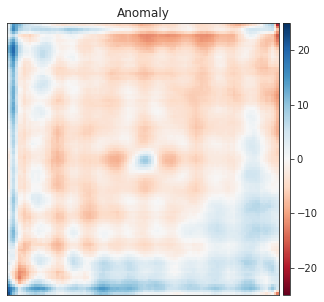

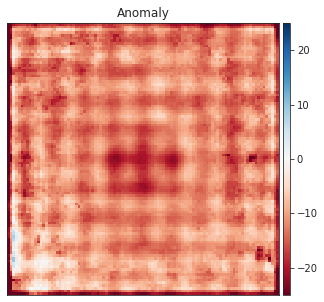

In [44]:
# calc means etc

mean_anom_unet = mean(real,pred_cnn)
plot_anomaly(mean_anom_unet,cmap='RdBu',plot='show',vmin=-25,vmax=25)

std_anom_unet = std(real,pred_cnn)
plot_anomaly(std_anom_unet,cmap = 'RdBu',plot='show',vmin=-25,vmax=25)


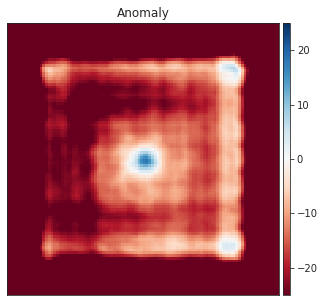

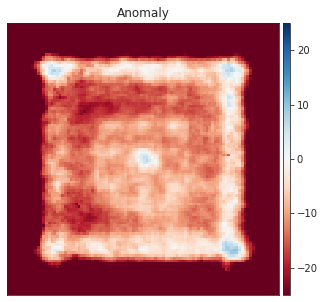

In [45]:
# calc means etc

mean_anom_vaegan = mean(real,pred_vaegan)
plot_anomaly(mean_anom_vaegan,cmap='RdBu',plot='show',vmin=-25,vmax=25)

std_anom_vaegan = std(real,pred_vaegan)
plot_anomaly(std_anom_vaegan,cmap = 'RdBu',plot='show',vmin=-25,vmax=25)



In [52]:
mean_anom_dsrnngan = mean(real,pred_dsrnngan)
plot_anomaly(mean_anom_dsrnngan,cmap='RdBu',plot='show',vmin=-50,vmax=50)

std_anom_dsrnngan = std(real,pred_dsrnngan)
plot_anomaly(std_anom_dsrnngan,cmap = 'RdBu',plot='show',vmin=-50,vmax=50)

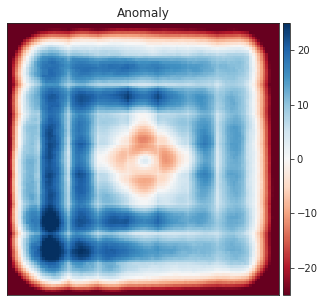

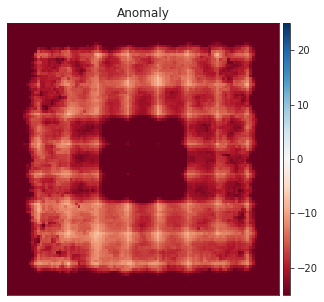

In [50]:
mean_anom_inputs = mean(real,inputs_hr)
plot_anomaly(mean_anom_inputs,cmap='RdBu',plot='show',vmin=-25,vmax=25)

std_anom_inputs = std(real,inputs_hr)
plot_anomaly(std_anom_inputs,cmap = 'RdBu',plot='show',vmin=-25,vmax=25)

show


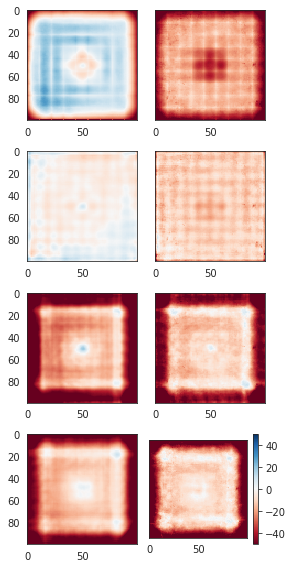

In [51]:
plot='show'
n = 4
m = 2
if plot == 'save':
		fig, axes = plt.subplots(n, m, figsize=(5*m, 5*n), sharey=True)
else:
		print('show')
		fig, axes = plt.subplots(n, m, figsize=(2*m, 2*n), sharey=True)


axes[0,0].imshow(mean_anom_inputs, interpolation='nearest', extent=None,cmap='RdBu',vmin=-50,vmax=50)
axes[1,0].imshow(mean_anom_unet, interpolation='nearest', extent=None,cmap='RdBu',vmin=-50,vmax=50)
axes[2,0].imshow(mean_anom_vaegan, interpolation='nearest', extent=None,cmap='RdBu',vmin=-50,vmax=50)
axes[3,0].imshow(mean_anom_dsrnngan, interpolation='nearest', extent=None,cmap='RdBu',vmin=-50,vmax=50)
axes[0,1].imshow(std_anom_inputs, interpolation='nearest', extent=None,cmap='RdBu',vmin=-50,vmax=50)
axes[1,1].imshow(std_anom_unet, interpolation='nearest', extent=None,cmap='RdBu',vmin=-50,vmax=50)
axes[2,1].imshow(std_anom_vaegan, interpolation='nearest', extent=None,cmap='RdBu',vmin=-50,vmax=50)
m = axes[3,1].imshow(std_anom_dsrnngan, interpolation='nearest', extent=None,cmap='RdBu',vmin=-50,vmax=50)
# axes.set_xticklabels=[]
# axes.set_yticklabels=[]

fig.tight_layout()

plt.colorbar(m)
plt.show()